In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Useremo uno di questi
from sklearn.metrics import f1_score # La nostra metrica di gara!

# --- Carichiamo i dati ---

# Assicurati che i file siano nella stessa cartella del notebook
# o aggiorna il percorso.
try:
    X_train_raw = pd.read_csv('/content/pirate_pain_train.csv')
    y_train_raw = pd.read_csv('/content/pirate_pain_train_labels.csv')
    X_test_raw = pd.read_csv('/content/pirate_pain_test.csv')

    print("--- Dati di Training (X_train_raw) ---")
    X_train_raw.info()

    print("\n--- Esempio di dati di Training ---")
    print(X_train_raw.head())

    print("\n--- Dati di Test (X_test_raw) ---")
    X_test_raw.info()

    print("\n--- Etichette (y_train_raw) ---")
    print(y_train_raw.head())
    print(f"\nClassi uniche: {y_train_raw['label'].unique()}")

except FileNotFoundError:
    print("Errore: File .csv non trovati.")
    print("Assicurati che 'pirate_pain_train.csv', 'pirate_pain_train_labels.csv' e 'pirate_pain_test.csv' siano nella cartella corretta.")

--- Dati di Training (X_train_raw) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  flo

In [2]:
# --- Verifica Integrità Dati ---

# 1. Controlliamo se il numero di campioni in X e y corrisponde
num_samples_x = X_train_raw['sample_index'].nunique()
num_samples_y = len(y_train_raw)

print(f"Campioni unici in X_train_raw: {num_samples_x}")
print(f"Campioni totali in y_train_raw: {num_samples_y}")
if num_samples_x == num_samples_y:
    print("✅ OK: Corrispondenza campioni X e y.")
else:
    print("⚠️ ATTENZIONE: Il numero di campioni in X e y NON corrisponde.")

# 2. Controlliamo la lunghezza delle sequenze
sequence_lengths = X_train_raw.groupby('sample_index').size()
print("\n--- Statistiche Lunghezza Sequenze ---")
print(sequence_lengths.describe())

# 3. Controlliamo se TUTTE le sequenze sono lunghe 180
if (sequence_lengths == 180).all():
    print("\n✅ OK: Tutte le sequenze hanno esattamente 180 time step.")
else:
    print("\n⚠️ ATTENZIONE: NON tutte le sequenze hanno 180 time step.")
    # Stampiamo quelle che non lo sono, se sono poche
    if len(sequence_lengths[sequence_lengths != 180]) < 20:
        print(f"Sequenze con lunghezza diversa da 180:\n{sequence_lengths[sequence_lengths != 180]}")
    else:
        print("Molte sequenze hanno una lunghezza diversa da 180.")


# 4. Controlliamo i valori unici delle features statiche (categoriche)
print("\n--- Valori Unici Features Statiche ---")
print(f"n_legs: {X_train_raw['n_legs'].unique()}")
print(f"n_hands: {X_train_raw['n_hands'].unique()}")
print(f"n_eyes: {X_train_raw['n_eyes'].unique()}")

Campioni unici in X_train_raw: 661
Campioni totali in y_train_raw: 661
✅ OK: Corrispondenza campioni X e y.

--- Statistiche Lunghezza Sequenze ---
count    661.0
mean     160.0
std        0.0
min      160.0
25%      160.0
50%      160.0
75%      160.0
max      160.0
dtype: float64

⚠️ ATTENZIONE: NON tutte le sequenze hanno 180 time step.
Molte sequenze hanno una lunghezza diversa da 180.

--- Valori Unici Features Statiche ---
n_legs: ['two' 'one+peg_leg']
n_hands: ['two' 'one+hook_hand']
n_eyes: ['two' 'one+eye_patch']


In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score
import warnings
from pandas.errors import SettingWithCopyWarning

# --- Setup Iniziale ---
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


# --- 1. Caricamento Dati ---
try:
    X_train_raw = pd.read_csv('/content/pirate_pain_train.csv')
    y_train_raw = pd.read_csv('/content/pirate_pain_train_labels.csv')
    X_test_raw = pd.read_csv('/content/pirate_pain_test.csv')
except FileNotFoundError:
    print("Errore: File .csv non trovati.")
    # Stop execution or handle error

# --- 2. Definizione Features e Label Encoding ---

# Liste delle colonne per tipo
TEMPORAL_FEATURES = [
    'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4',
    'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05',
    'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11',
    'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17',
    'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23',
    'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29',
    'joint_30'
] # Totale: 35 features

STATIC_FEATURES = ['n_legs', 'n_hands', 'n_eyes'] # Totale: 3 features

# Lunghezza delle sequenze (dalla nostra analisi)
SEQUENCE_LENGTH = 160

# --- Label Encoding ---
label_map = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
y_train = y_train_raw['label'].map(label_map).values
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

print(f"Features temporali identificate: {len(TEMPORAL_FEATURES)}")
print(f"Features statiche identificate: {len(STATIC_FEATURES)}")
print(f"Shape delle etichette (y_train_tensor): {y_train_tensor.shape}")
print(f"Prime 5 etichette: {y_train_tensor[:5]}")

Using device: cuda
Features temporali identificate: 35
Features statiche identificate: 3
Shape delle etichette (y_train_tensor): torch.Size([661])
Prime 5 etichette: tensor([0, 0, 1, 0, 0])


In [4]:
# Ignoriamo i warning di pandas durante lo scaling
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# --- 2. Scaler e Encoder (FONDAMENTALE: Fittati solo su X_train_raw) ---

# 2a. One-Hot Encoder per le features statiche
# Prendiamo i valori unici da X_train_raw per fittare l'encoder
static_data_train = X_train_raw[STATIC_FEATURES].drop_duplicates()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(static_data_train)

# 2b. Scaler per le features temporali
# Fittiamo lo scaler SOLO sui dati di training temporali
scaler = MinMaxScaler()
scaler.fit(X_train_raw[TEMPORAL_FEATURES])


# --- 3. Funzione di creazione sequenze ---

def create_sequences(x_df, y_series_or_none, seq_len, fitted_ohe, fitted_scaler):
    """
    Trasforma il dataframe "long" in un tensore 3D [campioni, timesteps, features]
    e applica OHE e Scaling.
    """

    # Lista per i dati 3D finali
    X_processed = []

    # ID unici (661 per il train, 1177 per il test)
    sample_indices = x_df['sample_index'].unique()

    # Raggruppa per 'sample_index'
    # Questo è più robusto di un reshape se i dati non fossero ordinati
    grouped = x_df.groupby('sample_index')

    for sample_idx in sample_indices:
        group = grouped.get_group(sample_idx)

        # --- 3a. Processa features temporali ---
        # Ordina per tempo (sicurezza) e prendi le features
        temporal_data = group.sort_values('time')[TEMPORAL_FEATURES]
        # Applica lo scaler fittato
        temporal_data_scaled = fitted_scaler.transform(temporal_data)

        # --- 3b. Processa features statiche ---
        # Prendi solo la prima riga (sono tutte uguali)
        static_data = group[STATIC_FEATURES].iloc[0:1]
        # Applica l'OHE fittato
        static_data_encoded = fitted_ohe.transform(static_data) # Shape (1, 6)

        # --- 3c. Combina ---
        # Ripeti ("tile") le features statiche per ogni time step
        # (1, 6) -> (160, 6)
        static_data_tiled = np.tile(static_data_encoded, (seq_len, 1))

        # Concatena temporali (160, 35) e statiche (160, 6)
        # Risultato -> (160, 41)
        combined_features = np.concatenate([temporal_data_scaled, static_data_tiled], axis=1)

        X_processed.append(combined_features)

    # Converte la lista di array (661) in un unico array 3D
    X_tensor = torch.tensor(np.array(X_processed), dtype=torch.float32)

    # Se stiamo processando il test set, non abbiamo y
    if y_series_or_none is None:
        return X_tensor

    # Altrimenti, processiamo anche y (già fatto fuori, ma per coerenza)
    y_tensor = torch.tensor(y_series_or_none, dtype=torch.long)
    return X_tensor, y_tensor


# --- 4. Applica la funzione ---

print("Inizio preprocessing X_train...")
# Processiamo i dati di training (passando le etichette già encodate)
X_train_tensor, y_train_tensor = create_sequences(X_train_raw, y_train, SEQUENCE_LENGTH, ohe, scaler)
print(f"Shape X_train_tensor: {X_train_tensor.shape}") # Atteso: (661, 160, 41)
print(f"Shape y_train_tensor: {y_train_tensor.shape}") # Atteso: (661)

print("\nInizio preprocessing X_test...")
# Processiamo i dati di test (passando None per le y)
X_test_tensor = create_sequences(X_test_raw, None, SEQUENCE_LENGTH, ohe, scaler)
print(f"Shape X_test_tensor: {X_test_tensor.shape}") # Atteso: (1177, 160, 41)

# Salviamo il numero totale di features per il modello
total_features = X_train_tensor.shape[2]
print(f"\nNumero totale di features (temporali + statiche OHE): {total_features}")

Inizio preprocessing X_train...
Shape X_train_tensor: torch.Size([661, 160, 41])
Shape y_train_tensor: torch.Size([661])

Inizio preprocessing X_test...
Shape X_test_tensor: torch.Size([1324, 160, 41])

Numero totale di features (temporali + statiche OHE): 41


In [5]:
# --- 5. Creazione Validation Split ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tensor,
    y_train_tensor,
    test_size=0.2, # 20% per la validazione
    random_state=SEED,
    stratify=y_train_tensor # FONDAMENTALE!
)

print(f"Shape X_train_split: {X_train_split.shape}")
print(f"Shape X_val_split:   {X_val_split.shape}")

# --- 6. Creazione DataLoaders (con FIX per CPU) ---

def make_loader(ds, batch_size, shuffle, drop_last):

    # *** FIX: Abilita pin_memory solo se siamo su CUDA ***
    pin_memory_enabled = (device.type == 'cuda')

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=2,
        pin_memory=pin_memory_enabled, # <-- FIX
        pin_memory_device=str(device) if pin_memory_enabled else "", # <-- FIX
        prefetch_factor=4 if pin_memory_enabled else 2,
    )

BATCH_SIZE = 64

train_ds = TensorDataset(X_train_split, y_train_split)
val_ds = TensorDataset(X_val_split, y_val_split)

train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("\nDataLoaders creati.")
print(f"Batch size: {BATCH_SIZE}")

Shape X_train_split: torch.Size([528, 160, 41])
Shape X_val_split:   torch.Size([133, 160, 41])

DataLoaders creati.
Batch size: 64


In [6]:
import torch.optim as optim
import os
import copy
from torch.utils.tensorboard import SummaryWriter

# --- 1. Definizione del Modello (da Lab 4) ---
# Adattato per la tua task

class RecurrentClassifier(nn.Module):
    """
    Classifier RNN generico (RNN, LSTM, GRU).
    Usa l'ultimo hidden state per la classificazione (Many-to-One).
    """
    def __init__(
            self,
            input_size,       # Nostro: 41
            hidden_size,      # Es. 128
            num_layers,       # Es. 2
            num_classes,      # Nostro: 3
            rnn_type='GRU',   # 'RNN', 'LSTM', o 'GRU'
            bidirectional=False,
            dropout_rate=0.0
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout solo tra i layer (se num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calcola l'input per il classificatore
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Layer di classificazione finale
        # Aggiungiamo il Dropout qui, come da Lab 2
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_input_size, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)
        rnn_out, hidden = self.rnn(x)

        # LSTM ritorna (h_n, c_n), a noi serve solo h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # Estrai l'ultimo hidden state dall'ultimo layer
        if self.bidirectional:
            # Reshape a (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            # Concatena l'ultimo fwd (hidden[-1, 0, ...]) e bwd (hidden[-1, 1, ...])
            # Shape finale: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Prendi l'hidden state dell'ultimo layer
            # Shape finale: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Ottieni i logits
        logits = self.classifier(hidden_to_classify)
        return logits

# --- 2. Funzioni di Training e Validazione (da Lab 2) ---

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Aggiungiamo L1/L2 (come da Lab 2)
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1

def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)
    # Puoi aggiungere l'histogramma dei pesi se vuoi (come nel Lab 2)

# --- 3. Funzione FIT (da Lab 2) ---

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Inizializziamo best_metric qui
    best_metric = float('-inf') if mode == 'max' else float('inf')

    if patience > 0:
        patience_counter = 0
        best_epoch = 0
        # Assicurati che la cartella 'models' esista
        os.makedirs("models", exist_ok=True)
        model_path = f"models/{experiment_name}_best_model.pt"

    print(f"Inizio training per {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        if epoch % verbose == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                  f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggerato dopo {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        print(f"Carico il modello migliore dall'epoch {best_epoch} con {evaluation_metric} {best_metric:.4f}")
        model.load_state_dict(torch.load(model_path))

    if writer is not None:
        writer.close()

    # *** FIX: Restituisci anche best_metric ***
    return model, training_history, best_metric

print("Definizioni del modello e delle funzioni di training caricate (FIX 2).")

Definizioni del modello e delle funzioni di training caricate (FIX 2).


In [7]:
# --- 5. Configurazione Esperimento Baseline ---

# Hyperparameters
LEARNING_RATE = 1e-3
EPOCHS = 200
PATIENCE = 20
L2_LAMBDA = 1e-4
DROPOUT_RATE = 0.3
HIDDEN_SIZE = 128
NUM_LAYERS = 2
RNN_TYPE = 'GRU'
BIDIRECTIONAL = True

# --- Inizializza Modello, Loss, Optimizer ---
print("Inizializzo il modello baseline...")

baseline_model = RecurrentClassifier(
    input_size=total_features, # 41
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=3,             # no_pain, low_pain, high_pain
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    dropout_rate=DROPOUT_RATE
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseline_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

scaler = torch.amp.GradScaler(device.type, enabled=(device.type == 'cuda'))

# Setup TensorBoard
experiment_name = f"{RNN_TYPE}_bidir={BIDIRECTIONAL}_hs={HIDDEN_SIZE}_nl={NUM_LAYERS}_dr={DROPOUT_RATE}"
writer = SummaryWriter(f"runs/{experiment_name}")

# --- 6. Avvia Training ---
print(f"Avvio training per: {experiment_name}")

# *** FIX: Cattura best_metric qui ***
baseline_model, history, best_metric = fit(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    patience=PATIENCE,
    evaluation_metric="val_f1",
    mode='max',
    restore_best_weights=True,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name
)

print("Training completato.")

Inizializzo il modello baseline...
Avvio training per: GRU_bidir=True_hs=128_nl=2_dr=0.3
Inizio training per 200 epochs...
Epoch   1/200 | Train: Loss=0.8021, F1=0.6471 | Val: Loss=0.7028, F1=0.6760
Epoch   2/200 | Train: Loss=0.6625, F1=0.6720 | Val: Loss=0.6898, F1=0.6760
Epoch   3/200 | Train: Loss=0.6624, F1=0.6773 | Val: Loss=0.6732, F1=0.6760
Epoch   4/200 | Train: Loss=0.6383, F1=0.6826 | Val: Loss=0.6602, F1=0.6760
Epoch   5/200 | Train: Loss=0.6361, F1=0.6746 | Val: Loss=0.6519, F1=0.6760
Epoch   6/200 | Train: Loss=0.6258, F1=0.6720 | Val: Loss=0.6431, F1=0.6760
Epoch   7/200 | Train: Loss=0.6052, F1=0.6800 | Val: Loss=0.6265, F1=0.6954
Epoch   8/200 | Train: Loss=0.6037, F1=0.7088 | Val: Loss=0.7109, F1=0.7331
Epoch   9/200 | Train: Loss=0.6166, F1=0.7150 | Val: Loss=0.6211, F1=0.6954
Epoch  10/200 | Train: Loss=0.5960, F1=0.7056 | Val: Loss=0.6188, F1=0.7107
Epoch  11/200 | Train: Loss=0.5845, F1=0.7280 | Val: Loss=0.6055, F1=0.7249
Epoch  12/200 | Train: Loss=0.5599, F1=0.

Valutazione del modello migliore sul Validation Set...

--- Metriche sul Validation Set ---
F1 Score (Weighted): 0.8724 (Il nostro best_metric era 0.8724)
Accuracy:              0.8797


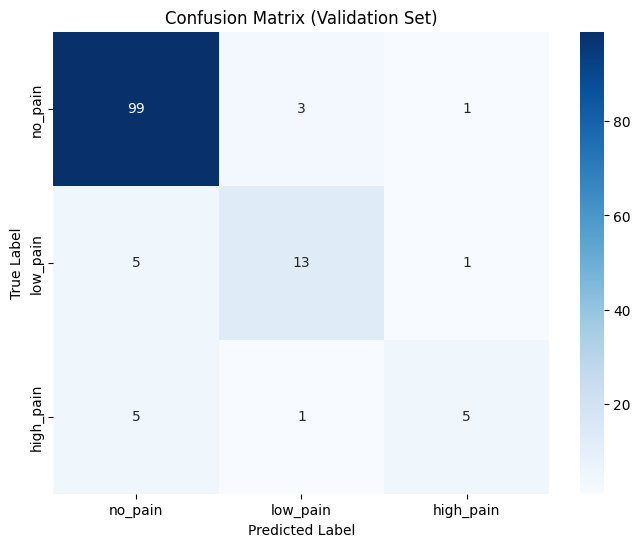

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# --- 7. Valutazione sul Validation Set ---
print("Valutazione del modello migliore sul Validation Set...")

baseline_model.eval()  # Mettiamo il modello in modalità valutazione
val_preds = []
val_targets = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        logits = baseline_model(inputs)
        preds = logits.argmax(dim=1)

        val_preds.append(preds.cpu().numpy())
        val_targets.append(targets.cpu().numpy())

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calcola metriche
val_f1 = f1_score(val_targets, val_preds, average='weighted')
val_acc = accuracy_score(val_targets, val_preds)

print(f"\n--- Metriche sul Validation Set ---")
print(f"F1 Score (Weighted): {val_f1:.4f} (Il nostro best_metric era {best_metric:.4f})")
print(f"Accuracy:              {val_acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(val_targets, val_preds)

# Mappa inversa per le etichette (da 0 -> 'no_pain')
inv_label_map = {v: k for k, v in label_map.items()}
class_names = [inv_label_map[i] for i in range(len(inv_label_map))]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [9]:
# --- 8. Predizione sul Test Set e Creazione Submission ---

print("Inizio predizione sul Test Set...")

# 1. Creiamo il Test Dataset e DataLoader
# (X_test_tensor è stato creato nella cella 2)
# Usiamo solo X_test_tensor, non ci sono etichette
test_ds = TensorDataset(X_test_tensor)

test_loader = make_loader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,  # MAI shuffle sul test set
    drop_last=False # MAI droppare dati sul test set
)

# 2. Eseguiamo la predizione
baseline_model.eval() # Modalità valutazione (disattiva dropout, ecc.)
all_test_preds = []

with torch.no_grad():
    for (inputs,) in test_loader: # Nota: (inputs,) perché non c'è la 'y'
        inputs = inputs.to(device)

        logits = baseline_model(inputs)
        preds = logits.argmax(dim=1)

        all_test_preds.append(preds.cpu().numpy())

# Concatena tutte le predizioni dei batch
test_predictions_int = np.concatenate(all_test_preds)

# 3. Riconverti i numeri (0, 1, 2) in etichette stringa
# (inv_label_map è stato definito nella cella precedente)
test_predictions_labels = [inv_label_map[pred] for pred in test_predictions_int]

# 4. Crea il DataFrame per la submission
# Dobbiamo prendere gli 'sample_index' unici da X_test_raw
submission_df = pd.DataFrame({
    'sample_index': X_test_raw['sample_index'].unique(),
    'label': test_predictions_labels
})

# 5. Salva il file .csv
submission_filename = 'submission_baseline.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nFile di submission creato: {submission_filename}")
print(f"Totale predizioni: {len(submission_df)}")
print("\nPrime 5 righe della submission:")
print(submission_df.head())

Inizio predizione sul Test Set...

File di submission creato: submission_baseline.csv
Totale predizioni: 1324

Prime 5 righe della submission:
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain


---
## 🎯 Fase 2: Ottimizzazione Iperparametri (Grid Search)

Abbiamo una baseline di 0.891. Ora, come nel Lab 3, proviamo a migliorare il punteggio
cercando una combinazione migliore di iperparametri.

Useremo un "Grid Search" manuale per testare diverse configurazioni, allenandole
sul `train_loader` e valutandole sul `val_loader` (gli stessi che abbiamo già creato).

In [13]:
import itertools

# --- 1. Definizione della Griglia di Ricerca (Grid Search) ---

# Definiamo gli iperparametri da testare
param_grid = {
    'HIDDEN_SIZE': [128, 256],      # Testiamo il nostro baseline (128) vs uno più grande (256)
    'NUM_LAYERS': [2, 3],          # Testiamo 2 layer (baseline) vs 3
    'DROPOUT_RATE': [0.3, 0.5],    # Testiamo il 30% (baseline) vs 50%
    'LEARNING_RATE': [1e-3]        # Per ora teniamo fisso il learning rate per velocità
}

# Parametri fissi del nostro esperimento
FIXED_PARAMS = {
    'RNN_TYPE': 'GRU',
    'BIDIRECTIONAL': True,
    'L2_LAMBDA': 1e-4,
    'EPOCHS': 200,
    'PATIENCE': 20,
    'CRITERION': nn.CrossEntropyLoss()
}

# Lista per salvare i risultati
grid_search_results = []
best_overall_f1 = 0.0
best_overall_config = {}

# Genera tutte le combinazioni
all_combinations = list(itertools.product(
    param_grid['HIDDEN_SIZE'],
    param_grid['NUM_LAYERS'],
    param_grid['DROPOUT_RATE'],
    param_grid['LEARNING_RATE']
))

print(f"Grid Search: {len(all_combinations)} combinazioni totali da testare.")

Grid Search: 8 combinazioni totali da testare.


In [14]:
%%time

# --- 2. Esecuzione del Grid Search (CORRETTA) ---

for i, (hs, nl, dr, lr) in enumerate(all_combinations):

    current_config = {
        'HIDDEN_SIZE': hs,
        'NUM_LAYERS': nl,
        'DROPOUT_RATE': dr,
        'LEARNING_RATE': lr
    }

    experiment_name = f"{FIXED_PARAMS['RNN_TYPE']}_bidir={FIXED_PARAMS['BIDIRECTIONAL']}_hs={hs}_nl={nl}_dr={dr}_lr={lr}"
    print(f"\n--- Inizio Test {i+1}/{len(all_combinations)}: {experiment_name} ---")

    # 1. Inizializza Modello
    model = RecurrentClassifier(
        input_size=total_features,
        hidden_size=hs,
        num_layers=nl,
        num_classes=3,
        rnn_type=FIXED_PARAMS['RNN_TYPE'],
        bidirectional=FIXED_PARAMS['BIDIRECTIONAL'],
        dropout_rate=dr
    ).to(device)

    # 2. Inizializza Optimizer e Scaler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=FIXED_PARAMS['L2_LAMBDA'])
    scaler = torch.amp.GradScaler(device.type, enabled=(device.type == 'cuda'))

    # 3. Inizializza Writer di TensorBoard
    writer = SummaryWriter(f"runs/{experiment_name}")

    # 4. Avvia il training (usando la nostra funzione 'fit')
    model, history, best_f1_metric = fit(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=FIXED_PARAMS['EPOCHS'],
        criterion=FIXED_PARAMS['CRITERION'],
        optimizer=optimizer,
        scaler=scaler,
        device=device,
        patience=FIXED_PARAMS['PATIENCE'],
        evaluation_metric="val_f1",
        mode='max',
        restore_best_weights=True,
        writer=writer,
        verbose=100, # <-- FIX: Cambiato da 0 a 100
        experiment_name=experiment_name
    )

    print(f"--- Risultato Test {i+1}: Val F1 = {best_f1_metric:.4f} ---")

    # Salva i risultati
    result = current_config.copy()
    result['val_f1'] = best_f1_metric
    grid_search_results.append(result)

    # Tieni traccia del migliore
    if best_f1_metric > best_overall_f1:
        best_overall_f1 = best_f1_metric
        best_overall_config = current_config.copy()
        print(f"🎉 NUOVO MIGLIOR PUNTEGGIO TROVATO! 🎉")

print("\n--- Grid Search Completato ---")


--- Inizio Test 1/8: GRU_bidir=True_hs=128_nl=2_dr=0.3_lr=0.001 ---
Inizio training per 200 epochs...
Epoch   1/200 | Train: Loss=0.7988, F1=0.6378 | Val: Loss=0.6914, F1=0.6760
Early stopping triggerato dopo 60 epochs.
Carico il modello migliore dall'epoch 40 con val_f1 0.8446
--- Risultato Test 1: Val F1 = 0.8446 ---
🎉 NUOVO MIGLIOR PUNTEGGIO TROVATO! 🎉

--- Inizio Test 2/8: GRU_bidir=True_hs=128_nl=2_dr=0.5_lr=0.001 ---
Inizio training per 200 epochs...
Epoch   1/200 | Train: Loss=0.7870, F1=0.6534 | Val: Loss=0.7053, F1=0.6760
Epoch 100/200 | Train: Loss=0.1248, F1=0.9583 | Val: Loss=0.5357, F1=0.8244
Early stopping triggerato dopo 104 epochs.
Carico il modello migliore dall'epoch 84 con val_f1 0.8599
--- Risultato Test 2: Val F1 = 0.8599 ---
🎉 NUOVO MIGLIOR PUNTEGGIO TROVATO! 🎉

--- Inizio Test 3/8: GRU_bidir=True_hs=128_nl=3_dr=0.3_lr=0.001 ---
Inizio training per 200 epochs...
Epoch   1/200 | Train: Loss=0.7585, F1=0.6474 | Val: Loss=0.6924, F1=0.6760
Epoch 100/200 | Train: Los

In [15]:
# --- 3. Visualizzazione Risultati Grid Search ---

print("--- Risultati del Grid Search ---")

# Converti i risultati in un DataFrame per una facile visualizzazione
results_df = pd.DataFrame(grid_search_results)
results_df = results_df.sort_values(by='val_f1', ascending=False)

print(results_df.to_markdown(index=False))

print("\n--- Configurazione Migliore ---")
print(f"Punteggio F1: {best_overall_f1:.4f}")
print(f"Iperparametri: {best_overall_config}")

--- Risultati del Grid Search ---
|   HIDDEN_SIZE |   NUM_LAYERS |   DROPOUT_RATE |   LEARNING_RATE |   val_f1 |
|--------------:|-------------:|---------------:|----------------:|---------:|
|           128 |            3 |            0.3 |           0.001 | 0.906243 |
|           128 |            3 |            0.5 |           0.001 | 0.878044 |
|           256 |            2 |            0.5 |           0.001 | 0.871668 |
|           256 |            3 |            0.5 |           0.001 | 0.863137 |
|           256 |            2 |            0.3 |           0.001 | 0.862601 |
|           128 |            2 |            0.5 |           0.001 | 0.859864 |
|           256 |            3 |            0.3 |           0.001 | 0.858983 |
|           128 |            2 |            0.3 |           0.001 | 0.844573 |

--- Configurazione Migliore ---
Punteggio F1: 0.9062
Iperparametri: {'HIDDEN_SIZE': 128, 'NUM_LAYERS': 3, 'DROPOUT_RATE': 0.3, 'LEARNING_RATE': 0.001}


In [16]:
# --- 1. Definizione e Caricamento Modello Vincente ---

# Definiamo la configurazione vincente del Grid Search
BEST_CONFIG = {
    'HIDDEN_SIZE': 128,
    'NUM_LAYERS': 3,
    'DROPOUT_RATE': 0.3,
    'RNN_TYPE': 'GRU',
    'BIDIRECTIONAL': True
}

# Inizializza il modello con questa architettura
new_best_model = RecurrentClassifier(
    input_size=total_features,
    hidden_size=BEST_CONFIG['HIDDEN_SIZE'],
    num_layers=BEST_CONFIG['NUM_LAYERS'],
    num_classes=3,
    rnn_type=BEST_CONFIG['RNN_TYPE'],
    bidirectional=BEST_CONFIG['BIDIRECTIONAL'],
    dropout_rate=BEST_CONFIG['DROPOUT_RATE']
).to(device)

# Definisci il path del modello salvato
# (corrisponde al nome dell'esperimento vincente)
model_path = "models/GRU_bidir=True_hs=128_nl=3_dr=0.3_lr=0.001_best_model.pt"

# Carica i pesi
new_best_model.load_state_dict(torch.load(model_path))
new_best_model.eval() # Metti in modalità valutazione

print(f"Modello vincente caricato da: {model_path}")

Modello vincente caricato da: models/GRU_bidir=True_hs=128_nl=3_dr=0.3_lr=0.001_best_model.pt


In [17]:
# --- 2. Predizione sul Test Set e Creazione Submission v2 ---

print("Inizio predizione sul Test Set con il modello ottimizzato...")

# (test_loader è già definito dalla cella 8)
# (BATCH_SIZE è già definito)

# Eseguiamo la predizione
all_test_preds = []
with torch.no_grad():
    for (inputs,) in test_loader:
        inputs = inputs.to(device)

        logits = new_best_model(inputs)
        preds = logits.argmax(dim=1)

        all_test_preds.append(preds.cpu().numpy())

test_predictions_int = np.concatenate(all_test_preds)

# Mappa inversa per le etichette (definita nella cella 7)
inv_label_map = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
test_predictions_labels = [inv_label_map[pred] for pred in test_predictions_int]

# Crea il DataFrame
submission_df_v2 = pd.DataFrame({
    'sample_index': X_test_raw['sample_index'].unique(),
    'label': test_predictions_labels
})

# Salva il nuovo file .csv
submission_filename = 'submission_gridsearch_v1.csv'
submission_df_v2.to_csv(submission_filename, index=False)

print(f"\nNuovo file di submission creato: {submission_filename}")
print(submission_df_v2.head())

Inizio predizione sul Test Set con il modello ottimizzato...

Nuovo file di submission creato: submission_gridsearch_v1.csv
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain
